# Introduction to image segmentation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Create a simple dataset
class SimpleDataset(Dataset):
    def __init__(self, size=100, image_size=128):
        self.size = size
        self.image_size = image_size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Create a random input image
        center_x = np.random.randint(0, self.image_size)
        center_y = np.random.randint(0, self.image_size)
        radius = np.random.randint(10, self.image_size // 4)

        x, y = torch.meshgrid(torch.arange(self.image_size), torch.arange(self.image_size))
        distance = ((x - center_x)**2 + (y - center_y)**2).sqrt()
        target = (distance < radius).float().unsqueeze(0)

        # Add noise to the target to create the input image
        noise = torch.randn(1, self.image_size, self.image_size) * 0.8
        input_image = target + noise

        return input_image, target

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


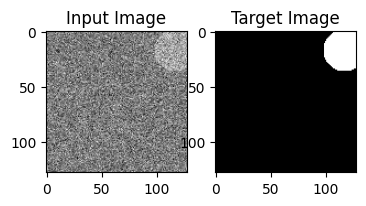

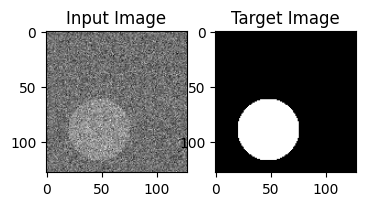

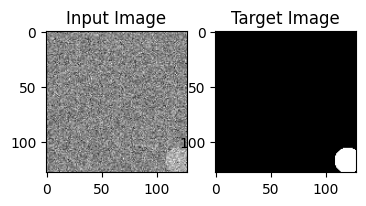

In [ ]:
import matplotlib.pyplot as plt
# Create an instance of the dataset
dataset = SimpleDataset(size=1, image_size=128)

# Get a sample from the dataset
for i in range(3):
    input_image, target = dataset[i]
    # Visualize the input image
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image[0], cmap='gray')
    plt.title('Input Image')
    # plt.show()
    # Visualize the target image
    plt.subplot(1, 2, 2)
    plt.imshow(target[0], cmap='gray')
    plt.title('Target Image')
    plt.show()
    # break


# Simple image to image

[Autoencoder](https://blog.paperspace.com/convolutional-autoencoder/)

In [ ]:
# Define a simple model with ConvTranspose2d
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layer to reduce spatial dimensions
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)
        # ConvTranspose2d layer to increase spatial dimensions
        self.conv_transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Downsample
        x = self.conv(x)
        # Upsample
        x = self.conv_transpose(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = SimpleDataset()
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
# Initialize the model, loss function, and optimizer
model = SimpleAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_loss = train_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

Epoch [1/50], Average Loss: 0.7022
Epoch [2/50], Average Loss: 0.6802
Epoch [3/50], Average Loss: 0.6711
Epoch [4/50], Average Loss: 0.6666
Epoch [5/50], Average Loss: 0.6548
Epoch [6/50], Average Loss: 0.6447
Epoch [7/50], Average Loss: 0.6332
Epoch [8/50], Average Loss: 0.6212
Epoch [9/50], Average Loss: 0.6156
Epoch [10/50], Average Loss: 0.6044
Epoch [11/50], Average Loss: 0.5966
Epoch [12/50], Average Loss: 0.5870
Epoch [13/50], Average Loss: 0.5814
Epoch [14/50], Average Loss: 0.5757
Epoch [15/50], Average Loss: 0.5688
Epoch [16/50], Average Loss: 0.5610
Epoch [17/50], Average Loss: 0.5555
Epoch [18/50], Average Loss: 0.5501
Epoch [19/50], Average Loss: 0.5461
Epoch [20/50], Average Loss: 0.5428
Epoch [21/50], Average Loss: 0.5375
Epoch [22/50], Average Loss: 0.5344
Epoch [23/50], Average Loss: 0.5317
Epoch [24/50], Average Loss: 0.5286
Epoch [25/50], Average Loss: 0.5247
Epoch [26/50], Average Loss: 0.5210
Epoch [27/50], Average Loss: 0.5193
Epoch [28/50], Average Loss: 0.5166
E

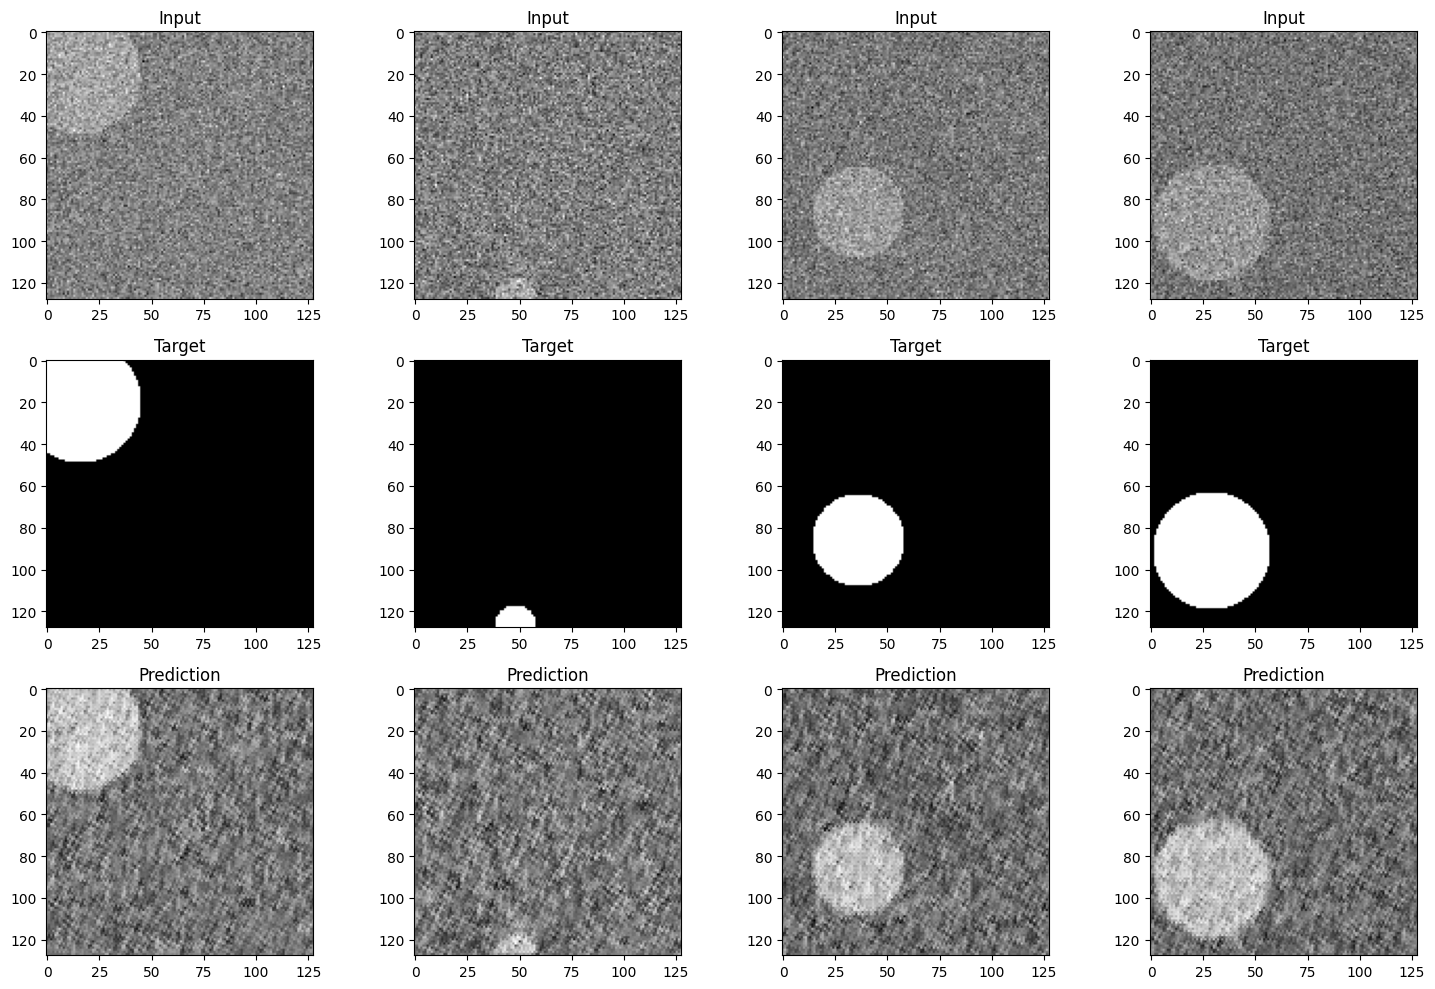

In [ ]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(train_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

In [ ]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Initialize the model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_loss = train_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

Epoch [1/50], Average Loss: 0.8651
Epoch [2/50], Average Loss: 0.8487
Epoch [3/50], Average Loss: 0.8031
Epoch [4/50], Average Loss: 0.7270
Epoch [5/50], Average Loss: 0.6934
Epoch [6/50], Average Loss: 0.6710
Epoch [7/50], Average Loss: 0.6591
Epoch [8/50], Average Loss: 0.6573
Epoch [9/50], Average Loss: 0.6550
Epoch [10/50], Average Loss: 0.6530
Epoch [11/50], Average Loss: 0.6538
Epoch [12/50], Average Loss: 0.6505
Epoch [13/50], Average Loss: 0.6520
Epoch [14/50], Average Loss: 0.6496
Epoch [15/50], Average Loss: 0.6490
Epoch [16/50], Average Loss: 0.6491
Epoch [17/50], Average Loss: 0.6475
Epoch [18/50], Average Loss: 0.6463
Epoch [19/50], Average Loss: 0.6462
Epoch [20/50], Average Loss: 0.6467
Epoch [21/50], Average Loss: 0.6457
Epoch [22/50], Average Loss: 0.6462
Epoch [23/50], Average Loss: 0.6452
Epoch [24/50], Average Loss: 0.6436
Epoch [25/50], Average Loss: 0.6432
Epoch [26/50], Average Loss: 0.6433
Epoch [27/50], Average Loss: 0.6435
Epoch [28/50], Average Loss: 0.6443
E

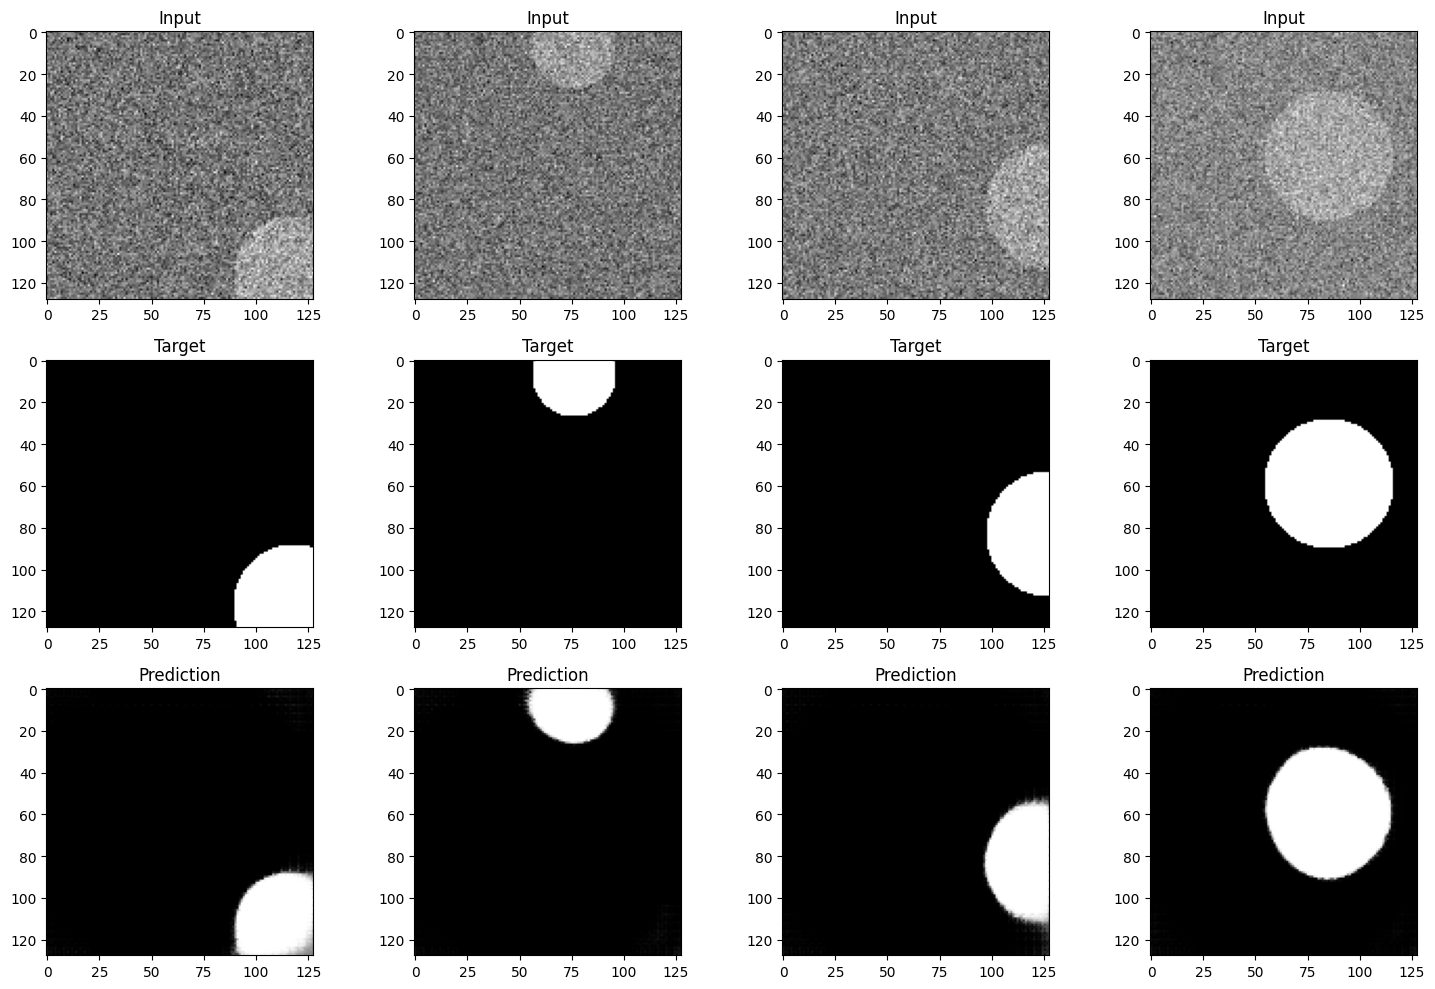

In [ ]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(train_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

# U-Net architecture
[Pytorch-UNet](https://github.com/milesial/Pytorch-UNet)

In [ ]:
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (upsampling)
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

In [ ]:
# Set up the model, loss function, and optimizer

model = UNet(in_channels=1, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Create the dataset and data loader
dataset = SimpleDataset()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Epoch 1/50, Loss: 0.4552
Epoch 2/50, Loss: 0.2274
Epoch 3/50, Loss: 0.1122
Epoch 4/50, Loss: 0.0964
Epoch 5/50, Loss: 0.0652
Epoch 6/50, Loss: 0.0532
Epoch 7/50, Loss: 0.0385
Epoch 8/50, Loss: 0.0169
Epoch 9/50, Loss: 0.0106
Epoch 10/50, Loss: 0.0113
Epoch 11/50, Loss: 0.0093
Epoch 12/50, Loss: 0.0090
Epoch 13/50, Loss: 0.0081
Epoch 14/50, Loss: 0.0075
Epoch 15/50, Loss: 0.0075
Epoch 16/50, Loss: 0.0079
Epoch 17/50, Loss: 0.0072
Epoch 18/50, Loss: 0.0067
Epoch 19/50, Loss: 0.0070
Epoch 20/50, Loss: 0.0071
Epoch 21/50, Loss: 0.0068
Epoch 22/50, Loss: 0.0067
Epoch 23/50, Loss: 0.0069
Epoch 24/50, Loss: 0.0067
Epoch 25/50, Loss: 0.0062
Epoch 26/50, Loss: 0.0066
Epoch 27/50, Loss: 0.0068
Epoch 28/50, Loss: 0.0062
Epoch 29/50, Loss: 0.0061
Epoch 30/50, Loss: 0.0061
Epoch 31/50, Loss: 0.0061
Epoch 32/50, Loss: 0.0062
Epoch 33/50, Loss: 0.0060
Epoch 34/50, Loss: 0.0057
Epoch 35/50, Loss: 0.0059
Epoch 36/50, Loss: 0.0058
Epoch 37/50, Loss: 0.0064
Epoch 38/50, Loss: 0.0061
Epoch 39/50, Loss: 0.

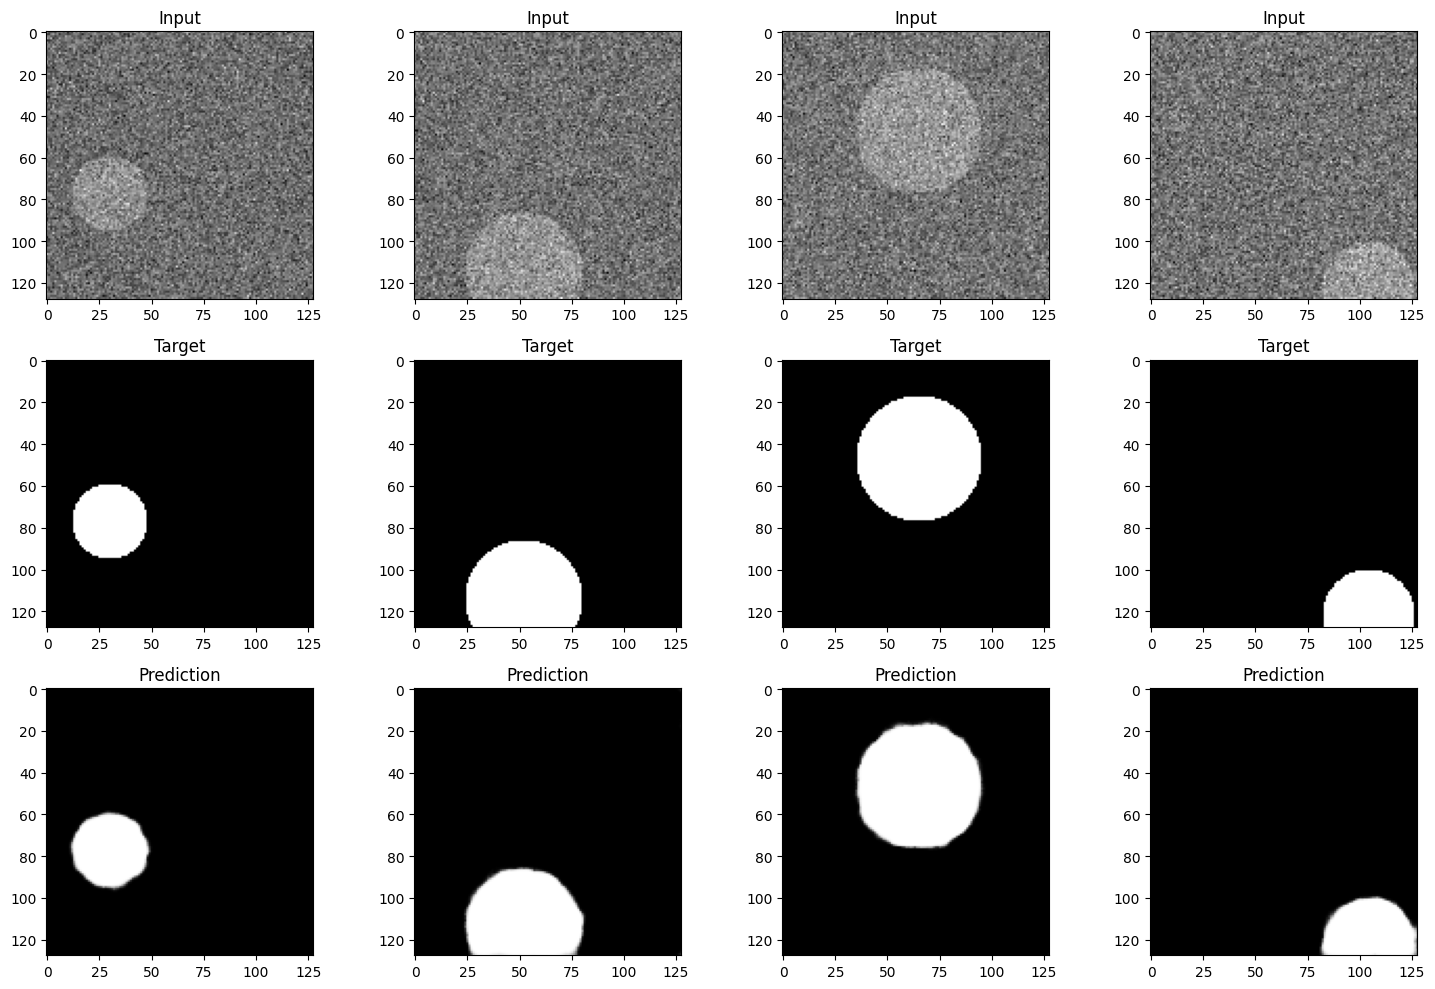

In [ ]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(dataloader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

In [ ]:
# !pip install torchviz

In [ ]:
# # Visualize the model architecture
# from torchviz import make_dot

# x = torch.randn(1, 1, 128, 128).to(device)
# y = model(x)
# dot = make_dot(y.mean(), params=dict(model.named_parameters()))
# dot.render("unet_architecture", format="png")

'unet_architecture.png'

# Multiple object

In [ ]:
class SimpleDataset(Dataset):
    def __init__(self, size=100, image_size=128):
        self.size = size
        self.image_size = image_size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Create a blank canvas for target
        target = torch.zeros(2, self.image_size, self.image_size)

        # Generate circle
        center_x = np.random.randint(0, self.image_size)
        center_y = np.random.randint(0, self.image_size)
        radius = np.random.randint(10, self.image_size // 6)
        x, y = torch.meshgrid(torch.arange(self.image_size), torch.arange(self.image_size))
        distance = ((x - center_x)**2 + (y - center_y)**2).sqrt()
        target[0] = (distance < radius).float()

        # Generate rectangle
        rect_x = np.random.randint(0, self.image_size - self.image_size // 4)
        rect_y = np.random.randint(0, self.image_size - self.image_size // 4)
        rect_w = np.random.randint(self.image_size // 8, self.image_size // 4)
        rect_h = np.random.randint(self.image_size // 8, self.image_size // 4)
        target[1, rect_x:rect_x+rect_w, rect_y:rect_y+rect_h] = 1

        # Combine circle and rectangle
        combined_target = (target.sum(dim=0) > 0).float().unsqueeze(0)

        # Add noise to create the input image
        noise = torch.randn(1, self.image_size, self.image_size) * 0.5
        input_image = combined_target + noise

        return input_image, target

In [ ]:
# Define the U-Net architecture (unchanged)
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (upsampling)
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

In [ ]:
# Set up the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Create the dataset and data loader
dataset = SimpleDataset()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

Epoch 1/50, Loss: 0.5601
Epoch 2/50, Loss: 0.2969
Epoch 3/50, Loss: 0.1402
Epoch 4/50, Loss: 0.0822
Epoch 5/50, Loss: 0.0695
Epoch 6/50, Loss: 0.0616
Epoch 7/50, Loss: 0.0649
Epoch 8/50, Loss: 0.0582
Epoch 9/50, Loss: 0.0576
Epoch 10/50, Loss: 0.0531
Epoch 11/50, Loss: 0.0548
Epoch 12/50, Loss: 0.0550
Epoch 13/50, Loss: 0.0517
Epoch 14/50, Loss: 0.0514
Epoch 15/50, Loss: 0.0535
Epoch 16/50, Loss: 0.0504
Epoch 17/50, Loss: 0.0522
Epoch 18/50, Loss: 0.0528
Epoch 19/50, Loss: 0.0526
Epoch 20/50, Loss: 0.0506
Epoch 21/50, Loss: 0.0516
Epoch 22/50, Loss: 0.0500
Epoch 23/50, Loss: 0.0579
Epoch 24/50, Loss: 0.0576
Epoch 25/50, Loss: 0.0528
Epoch 26/50, Loss: 0.0466
Epoch 27/50, Loss: 0.0535
Epoch 28/50, Loss: 0.0561
Epoch 29/50, Loss: 0.0551
Epoch 30/50, Loss: 0.0500
Epoch 31/50, Loss: 0.0511
Epoch 32/50, Loss: 0.0481
Epoch 33/50, Loss: 0.0504
Epoch 34/50, Loss: 0.0518
Epoch 35/50, Loss: 0.0637
Epoch 36/50, Loss: 0.0526
Epoch 37/50, Loss: 0.0475
Epoch 38/50, Loss: 0.0415
Epoch 39/50, Loss: 0.

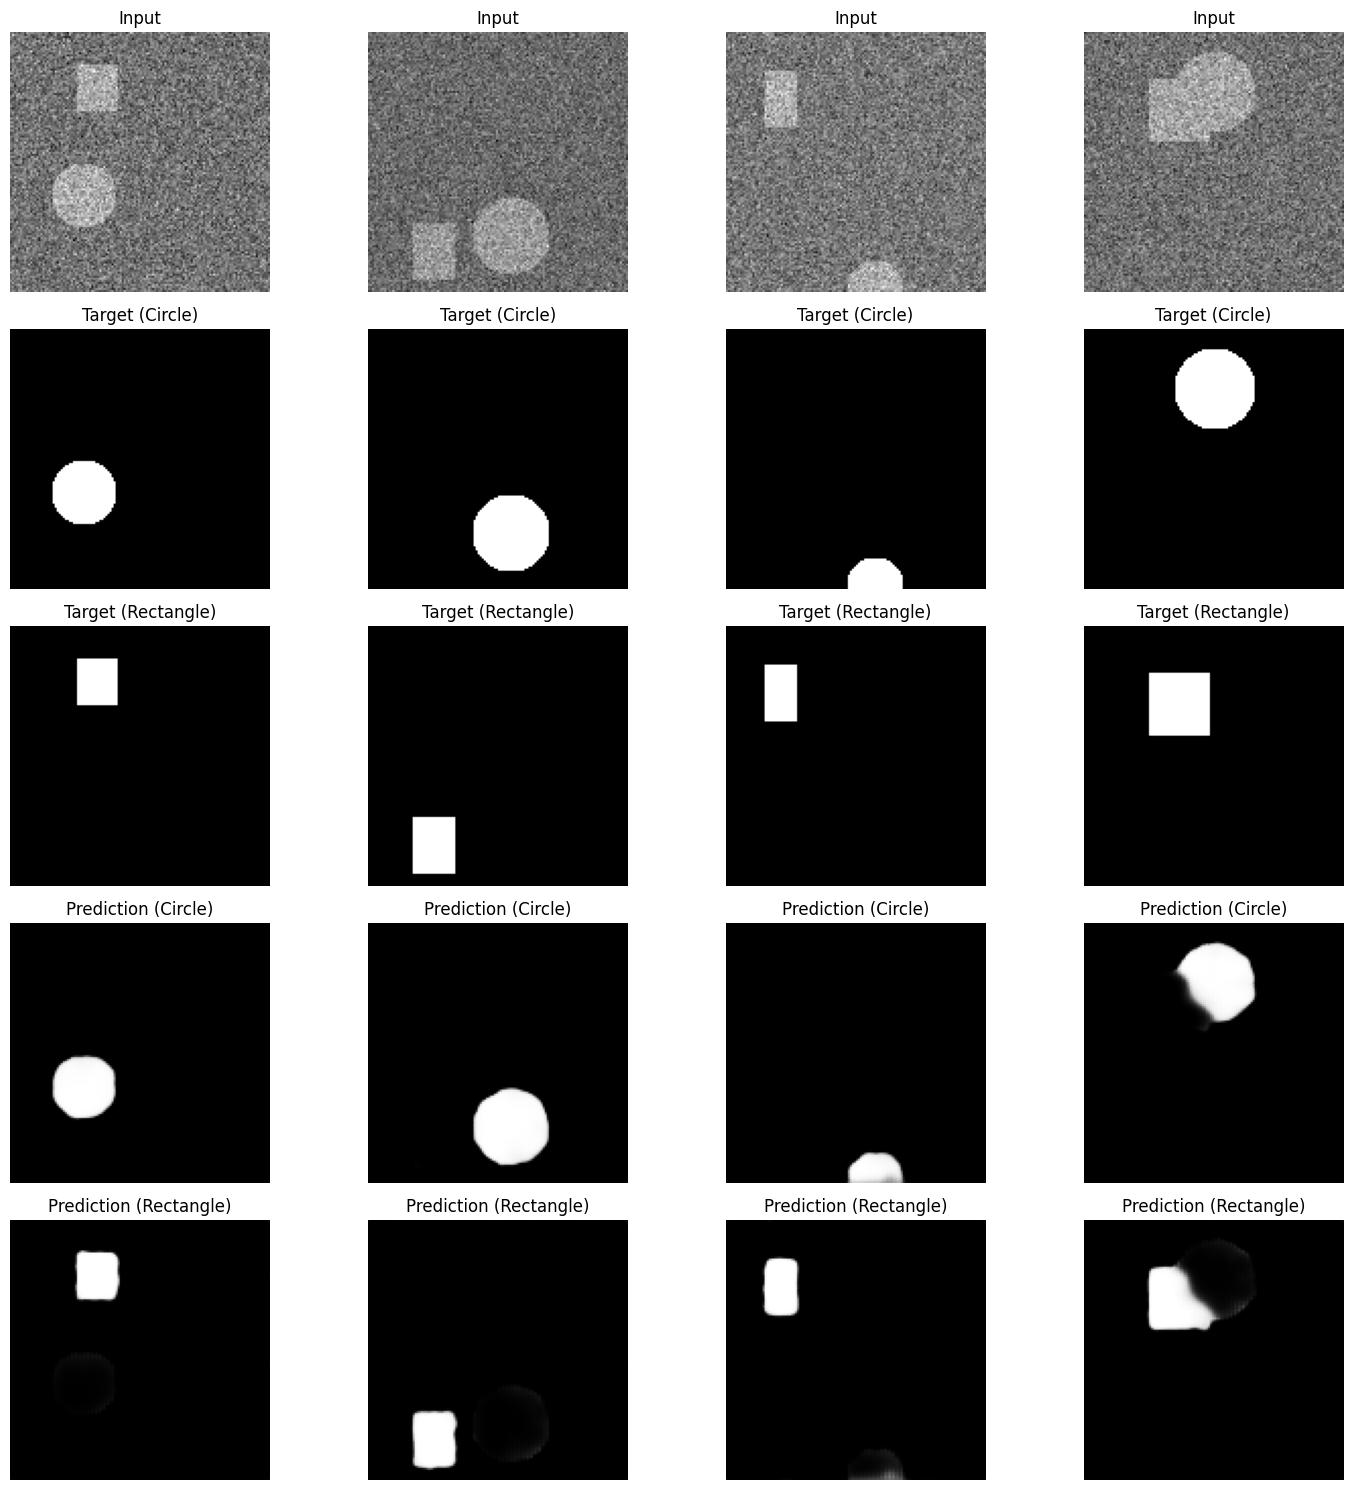

In [ ]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(dataloader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(5, 4, figsize=(15, 15))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[0, i].axis('off')

        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target (Circle)')
        axes[1, i].axis('off')

        axes[2, i].imshow(targets[i, 1].cpu(), cmap='gray')
        axes[2, i].set_title('Target (Rectangle)')
        axes[2, i].axis('off')

        axes[3, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[3, i].set_title('Prediction (Circle)')
        axes[3, i].axis('off')

        axes[4, i].imshow(outputs[i, 1].cpu(), cmap='gray')
        axes[4, i].set_title('Prediction (Rectangle)')
        axes[4, i].axis('off')

    plt.tight_layout()
    plt.show()

# Hand on

Revise the code to be able to segment 4 objects per image using U-Net.

# High performance and well known model
https://pytorch.org/vision/stable/models.html

https://universe.roboflow.com/
